In [197]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from saif.crs_model.peakdetector import pk_indxs
import saif.scinet.model as scinet
# plt.style.use('ggplot')

%matplotlib inline

In [196]:
# from saif.scinet.dataset import daily_seismic_and_interpolated_pressure
# from saif.scinet.dataset import construct_time_series_dataset

from dataset import daily_seismic_and_interpolated_pressure
from dataset import construct_time_series_dataset
from dataset import overlap_and_interpolate
from dataset import aggregate_seismic

from torch.utils.data import DataLoader

In [3]:
import pandas as pd
# seismic = pd.read_csv("../../data/02_intermediate/seismic.csv", index_col=0)
# pressure = pd.read_csv("../../data/02_intermediate/pressure.csv", index_col=0)

seismic_original = pd.read_csv("seismic.csv",index_col=0)
pressure_original = pd.read_csv("pressure.csv",index_col=0)

# seismic = seismic.drop(columns=['kmeans'])

seismic = pd.read_csv("temporal_datasets_decatur_illinois_seismic_new.csv",index_col=None)
pressure = pd.read_csv("temporal_datasets_decatur_illinois_pressure_new.csv",index_col=None)

pressure["epoch"] = pressure["epoch"]



In [4]:
features_original, target_vals_original = daily_seismic_and_interpolated_pressure(seismic_original, pressure_original)


In [5]:
features, target_vals = daily_seismic_and_interpolated_pressure(seismic, pressure)


In [6]:
input_len = 16 # try wider window power of 2
horizon = 7 # prediction window

# Trying out different input_len and horizon
input_len = 64
horizon = 7

In [7]:
features = features[['pressure','dpdt','seismic']]

In [8]:
features

,pressure,dpdt,seismic
0,8.599065e+06,0.017439,1.0
1,8.601838e+06,0.018007,1.0
2,8.604612e+06,0.018575,2.0
3,8.607385e+06,0.019143,2.0
4,8.610158e+06,0.019711,2.0
...,...,...,...
1106,8.652984e+06,-0.029754,4886.0
1107,8.649775e+06,-0.030196,4886.0
1108,8.646565e+06,-0.030638,4889.0
1109,8.643355e+06,-0.031079,4890.0


Visualization of the train / test split

Text(0, 0.5, 'normalized cumulative counts')

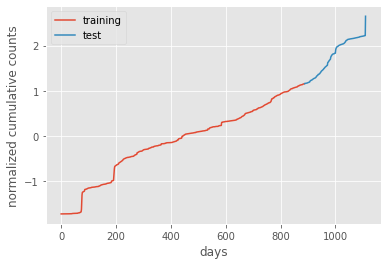

In [80]:
train_dset, test_dset, x_scaler, y_scaler = construct_time_series_dataset(
    features, target_vals, 
    input_len, horizon, features.columns, 
    train_test_split=0.8, normalize_data=True # try train_test_split=0.75
    # train_test_split=0.75, normalize_data=True
)

plt.figure()
plt.plot(np.arange(len(train_dset.Y)), train_dset.Y, label='training')
plt.plot(np.arange(len(test_dset.Y)) + len(train_dset.Y), test_dset.Y, label='test')
plt.legend()
plt.xlabel('days')
plt.ylabel('normalized cumulative counts')

### Model Architecture

In [10]:
class SimpleSCINet(nn.Module):
    def __init__(
        self, 
        input_len, output_len,
        input_dim, num_levels, kernel_size, dropout, groups, hidden_size
    ):
        super().__init__()
        
        self.input_len = input_len
        self.output_len = output_len
        self.input_dim = input_dim
        self.hidden_size = hidden_size
        self.num_levels = num_levels
        self.groups = groups
        self.kernel_size = kernel_size
        self.dropout = dropout
        
        self.bn1 = nn.BatchNorm1d(self.input_dim)
        self.bn2 = nn.BatchNorm1d(self.input_dim)
        
        self.block1 = scinet.EncoderTree(
            in_planes=self.input_dim,
            num_levels=self.num_levels,
            kernel_size=self.kernel_size,
            dropout=self.dropout,
            groups=self.groups,
            hidden_size=self.hidden_size,
            INN=True
        )
        
        # I'm a bit iffy on using a projector like this across features
        # But this is what they do in scinet
        # It should be fine, kernel size is 1, it's essentially just an
        # aggregation operation
        self.time_projector = nn.Conv1d(
            self.input_len, self.output_len,
            kernel_size=1, stride=1, bias=False
        )
        
        self.channel_projector = nn.Conv1d(
            self.input_dim, 1, kernel_size=1, stride=1, bias=True
        )
    
    def forward(self, x):
        out = x.permute(0, 2, 1)
        out = self.bn1(out)
        out = out.permute(0, 2, 1)
        
        out = self.block1(out)
        out += out
        
        out = F.relu(out)
        out = self.time_projector(out)
        
        out = out.permute(0, 2, 1)
        out = self.bn2(out)
        out = F.relu(out)
        
        out = self.channel_projector(out).squeeze(1)
        
        #Enforcing monotonicity
        #out = torch.exp(out)
        #out = F.relu(out)
        # Exp has numerical issues, and relu was collapsing.
        # Squaring is also a positive operation
        out = out ** 2
        #out = torch.sigmoid(out)
        out = out.cumsum(-1) + x[:, -1, -1, None]
        
        return out

### Hyperparameters

In [11]:
input_dim = train_dset.X.shape[1]
num_levels = 2 # number of levels in the scinet tree
kernel_size = 4 # kernel size for the conv1D operations
dropout = 0.5 # dropout regularization params
groups = 1 # number of groups in the conv1D operation
hidden_size = 3 # scaling factor for the hidden dimension

lr = 1e-3 # learning rate
# n_epoch = 64 # number of epochs
n_epoch = 64

# Choose your loss function!/
# criterion = nn.MSELoss() # L2 loss
criterion = nn.HuberLoss() #An alternative, smoother version of the L1 Loss
# Less sensitive to outliers, less prone to exploding gradients

### Run Training

In [12]:

from tqdm.notebook import tqdm

In [13]:
torch.manual_seed(0) # Use different seeds for 10 times

train_loader = DataLoader(
    train_dset,
    batch_size=32,
    shuffle=True,
    num_workers=1
)

test_loader = DataLoader(
    test_dset,
    batch_size=32,
    shuffle=False,
    num_workers=1
)

model = SimpleSCINet(
    input_len, horizon,
    input_dim, num_levels, kernel_size, 
    dropout, groups, hidden_size
)

optimizer = optim.Adam(model.parameters(), lr=lr)

train_loss_vals = []
test_loss_vals = []


for epoch in tqdm(range(n_epoch)):
    #train loop
    model.train()
    batch_loss_vals = []
    for (batch_x, batch_y) in train_loader:
        optimizer.zero_grad()
        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        batch_loss_vals.append(loss.item())
    train_loss_vals.append(np.mean(batch_loss_vals))
    
    #eval loop
    model.eval()
    batch_loss_vals = []
    for (batch_x, batch_y) in test_loader:        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        batch_loss_vals.append(loss.item())
    test_loss_vals.append(np.mean(batch_loss_vals))

  0%|          | 0/64 [00:00<?, ?it/s]

In [14]:
# print Huber Loss
test_loss_vals

[0.02121907230466604,
 0.011216092389076948,
 0.0036151260952465235,
 0.0019868467934429646,
 0.0012910275196190923,
 0.0008611781406216324,
 0.0008153581293299794,
 0.0006570254394318908,
 0.0006174041453050449,
 0.0006498607312096283,
 0.0005657352652633562,
 0.0005425499490229413,
 0.0005994760867906734,
 0.0005485319357831031,
 0.0005253418261418119,
 0.0005494867829838768,
 0.000514112004020717,
 0.0005395178770413623,
 0.0005481574866280425,
 0.0004986188912880607,
 0.000517509356723167,
 0.0005570879995502765,
 0.0005339737286703894,
 0.0005767142924014479,
 0.0005423267020887579,
 0.0005930806564720115,
 0.0005546873198909452,
 0.0005902206074097193,
 0.0005926412603002972,
 0.0005847632244694978,
 0.0005834336072439328,
 0.0005983779723464977,
 0.0005690267134923488,
 0.0006001991403536521,
 0.0005943776610365603,
 0.000576672176248394,
 0.0005820262602355796,
 0.0005624245357466861,
 0.0005743078349041752,
 0.0005768570903455838,
 0.0005428458694950678,
 0.0005479761384776793

Text(0.5, 0, 'Epoch')

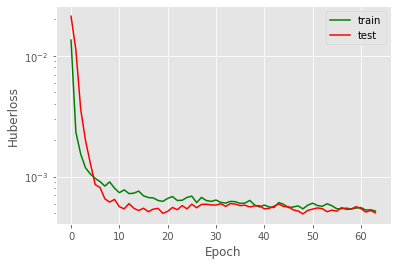

In [15]:
plt.plot(train_loss_vals, color='g', label='train')
plt.plot(test_loss_vals, color='r', label='test')
plt.legend()
plt.ylabel('Huberloss')
# plt.ylim([0,2])
plt.yscale('log')
plt.xlabel('Epoch')

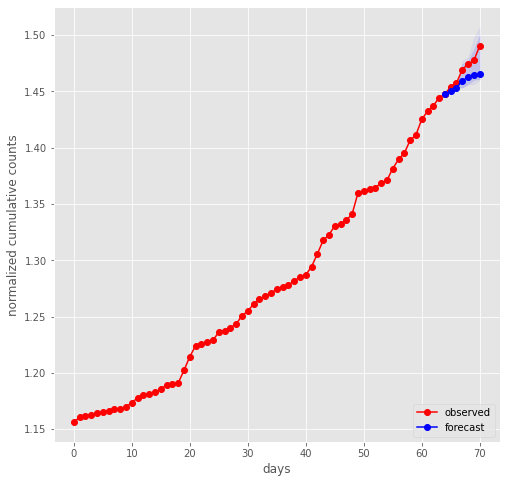

In [18]:
start_input = 0
end_input = start_input + input_len
end_output = end_input + horizon

sample_x = torch.clone(test_dset.X[start_input:end_input])
input_y = torch.clone(test_dset.Y[start_input:end_input+1])
output_y = torch.clone(test_dset.Y[end_input:end_output])

def monte_carlo_sample(model, x, n_samples=50, seed=0):
    torch.manual_seed(seed)
    model.train()
    
    # We want the model to be in training mode
    # Except for the BN.
    # There is potentially a more elegant way to do this
    # Ex by making a different "mode" in our own model groups
    model.bn1.training = False
    model.bn2.training = False
    
    samples = []
    for _ in range(n_samples):
        samples.append(model(x).data)
    samples = torch.stack(samples)
    
    model.eval()
    return samples.permute(1, 0, 2)

model.eval()
pred_y = model(sample_x[None, :, :]).squeeze(0).data

samples = monte_carlo_sample(model, sample_x[None, :, :], n_samples=10)
samples = samples.squeeze(0).data.numpy()

sample_mean = samples.mean(0)
sample_std = samples.std(0)

## You can use mean +/- std, or percentile, to visualize the distribtion

# Uncomment to use mean +/- std
#sample_ub = sample_mean + sample_std
#sample_lb = sample_mean - sample_std

# Use percentiles
sample_ub = np.percentile(samples, 90, axis=0)
sample_lb = np.percentile(samples, 10, axis=0)

sample_max = samples.max(0)
sample_min = samples.min(0)

fig, ax = plt.subplots(1, 1, figsize=(8,8))

ax.plot(np.arange(start_input, end_input+1), input_y, 'r', marker='o', label='observed')
ax.plot(np.arange(end_input, end_output), output_y, 'r', marker='o')
ax.fill_between(np.arange(end_input, end_output), sample_ub, sample_lb, alpha=0.1, color='b')
ax.fill_between(np.arange(end_input, end_output), sample_max, sample_min, alpha=0.05, color='b')
ax.plot(np.arange(end_input, end_output), pred_y, 'b', marker='o', label='forecast')

plt.xlabel('days')
plt.ylabel('normalized cumulative counts')
plt.legend(loc='lower right')
plt.show()

Visualize the forecast

## Trying out new prediction routine 

In [139]:
n_horizons_forcast = 32
start_input = 0
end_input = start_input + input_len
end_output = end_input + n_horizons_forcast*horizon

# sample_x = torch.clone(test_dset.X[start_input:end_input])
# input_y = torch.clone(test_dset.Y[start_input:end_input+1])
# output_y = torch.clone(test_dset.Y[end_input:end_output])

sample_x = torch.clone(train_dset.X[-input_len:])
input_y = torch.clone(train_dset.Y[-input_len:])
# output_y = torch.clone(test_dset.Y[start_input:start_input+n_horizons_forcast*horizon])


# forecast_X = torch.clone(train_dset.X[-input_len:])
forecast_X = torch.cat((torch.clone(train_dset.X[-input_len:]),torch.clone(test_dset.X)))
# output_y = torch.cat((
#     # torch.clone(train_dset.Y[-input_len:]),
#     torch.clone(test_dset.Y)
# ))
output_y = torch.clone(test_dset.Y[:-1])


In [140]:
test_dset.Y

tensor([1.1563, 1.1604, 1.1620, 1.1628, 1.1644, 1.1652, 1.1660, 1.1676, 1.1676,
        1.1701, 1.1733, 1.1781, 1.1806, 1.1814, 1.1830, 1.1854, 1.1894, 1.1902,
        1.1910, 1.2023, 1.2144, 1.2241, 1.2257, 1.2274, 1.2290, 1.2362, 1.2370,
        1.2403, 1.2435, 1.2508, 1.2548, 1.2612, 1.2653, 1.2685, 1.2709, 1.2742,
        1.2766, 1.2782, 1.2814, 1.2855, 1.2871, 1.2943, 1.3056, 1.3177, 1.3226,
        1.3306, 1.3323, 1.3355, 1.3411, 1.3597, 1.3613, 1.3637, 1.3645, 1.3686,
        1.3710, 1.3815, 1.3896, 1.3952, 1.4065, 1.4113, 1.4251, 1.4323, 1.4372,
        1.4444, 1.4476, 1.4541, 1.4573, 1.4694, 1.4743, 1.4775, 1.4904, 1.4945,
        1.4993, 1.5098, 1.5170, 1.5227, 1.5267, 1.5324, 1.5396, 1.5461, 1.5526,
        1.5582, 1.5598, 1.5630, 1.6179, 1.6284, 1.6357, 1.6389, 1.6534, 1.6631,
        1.6712, 1.6833, 1.6881, 1.6913, 1.6986, 1.7381, 1.7535, 1.7688, 1.7728,
        1.7841, 1.7962, 1.8011, 1.8075, 1.8116, 1.8124, 1.8132, 1.8148, 1.8172,
        1.8213, 1.8261, 1.8277, 1.8293, 

In [141]:
torch.manual_seed(0)
model.eval()
predictions = []
outputs_y = []
sample_x = torch.clone(forecast_X[start_input:end_input])
for i in range(n_horizons_forcast):
    _predict = model(sample_x[None,:,:])
    predictions.append(_predict.data.squeeze()) # output?
    sample_x = torch.clone(forecast_X[start_input+i*horizon:end_input+i*horizon])
    sample_x[None,-horizon:,-1] = _predict.data.squeeze() # replacing last seismic data with the prediction
    # model.eval()



# outputs_y.append(output_y)
# _predict = model(sample_x[None,:,:])
# predictions.append(_predict.data.squeeze())

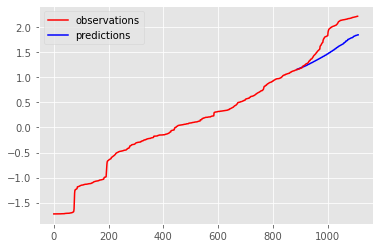

In [142]:
plt.plot(np.arange(0,len(train_dset.Y)),train_dset.Y,'r',label='observations')
plt.plot(np.arange(len(train_dset.Y),len(train_dset.Y)+len(torch.cat(predictions))),torch.cat(predictions).squeeze(),'b',label='predictions')
plt.plot(np.arange(len(train_dset.Y),len(train_dset.Y)+len(output_y)),output_y,'r')
plt.legend()

In [127]:
predictions_array = np.array(torch.cat(predictions))

In [144]:
forecast_df = pd.DataFrame({
    'days':np.arange(len(train_dset.Y),len(train_dset.Y)+len(output_y)),
    'predictions':predictions_array[0:len(output_y)],
    'observations': output_y
})

In [146]:
forecast_df.to_csv('forecasting.csv',index=None)

In [167]:
predictions_cumulative = y_scaler.inverse_transform(np.array(torch.cat(predictions)).reshape(-1,1)).squeeze()

In [161]:
output_y_cumulative = y_scaler.inverse_transform(np.array(output_y).reshape(-1,1))

In [163]:
train_y_cumulative = y_scaler.inverse_transform(np.array(train_dset.Y).reshape(-1,1))

In [175]:
train_days = np.arange(0,len(train_dset.Y))
train_years = train_days / 365.25

array([0.        , 0.00273785, 0.0054757 , 0.00821355, 0.0109514 ,
       0.01368925, 0.0164271 , 0.01916496, 0.02190281, 0.02464066,
       0.02737851, 0.03011636, 0.03285421, 0.03559206, 0.03832991,
       0.04106776, 0.04380561, 0.04654346, 0.04928131, 0.05201916,
       0.05475702, 0.05749487, 0.06023272, 0.06297057, 0.06570842,
       0.06844627, 0.07118412, 0.07392197, 0.07665982, 0.07939767,
       0.08213552, 0.08487337, 0.08761123, 0.09034908, 0.09308693,
       0.09582478, 0.09856263, 0.10130048, 0.10403833, 0.10677618,
       0.10951403, 0.11225188, 0.11498973, 0.11772758, 0.12046543,
       0.12320329, 0.12594114, 0.12867899, 0.13141684, 0.13415469,
       0.13689254, 0.13963039, 0.14236824, 0.14510609, 0.14784394,
       0.15058179, 0.15331964, 0.15605749, 0.15879535, 0.1615332 ,
       0.16427105, 0.1670089 , 0.16974675, 0.1724846 , 0.17522245,
       0.1779603 , 0.18069815, 0.183436  , 0.18617385, 0.1889117 ,
       0.19164956, 0.19438741, 0.19712526, 0.19986311, 0.20260

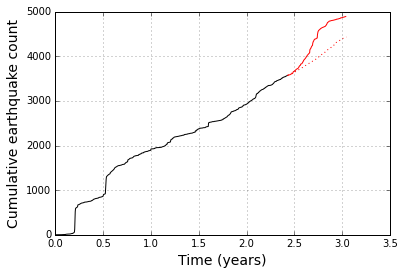

In [199]:
# plt.style.use('classic')
# plt.rcParams["figure.figsize"] = (8,6)
fig = plt.figure()
# plt.plot(np.arange(0,len(train_dset.Y)) / 365.25,train_y_cumulative,'-k',label='observations')
plt.plot(np.arange(0,len(train_dset.Y)) / 365.25,train_y_cumulative,'-k')
# plt.plot(np.arange(len(train_dset.Y),len(train_dset.Y)+len(torch.cat(predictions))) / 365.25 ,predictions_cumulative,':r',label='predictions')
plt.plot(np.arange(len(train_dset.Y),len(train_dset.Y)+len(torch.cat(predictions))) / 365.25 ,predictions_cumulative,':r')
plt.plot(np.arange(len(train_dset.Y),len(train_dset.Y)+len(output_y)) / 365.25,output_y_cumulative,'r')
# plt.legend()
plt.ylabel('Cumulative earthquake count', fontsize=14)
plt.xlabel('Time (years)', fontsize=14)
plt.grid(linestyle=':', alpha=0.7)
# plt.tight_layout()

tensor([[-5.1091,  1.3078, -1.7252],
        [-4.9977,  1.3624, -1.7252],
        [-4.8863,  1.4170, -1.7244],
        ...,
        [ 0.3983,  0.0314,  1.1523],
        [ 0.4113,  0.0230,  1.1547],
        [ 0.4242,  0.0146,  1.1555]])